In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2024-08-19 12:09:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  86.9MB/s    in 1.2s    

2024-08-19 12:09:39 (86.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [1]:
pip install wfdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 12.6 MB/s eta 0:00:00


In [4]:
import wfdb
import matplotlib.pyplot as plt

# Read the ECG record (assuming the data file is in the same directory)
record = wfdb.rdrecord('/content/drive/MyDrive/100_sample_ecg/100')
annotation = wfdb.rdann('/content/drive/MyDrive/100_sample_ecg/100', 'atr')

# Display information about the record
print(f"Record name: {record.record_name}")
print(f"Number of signals: {record.n_sig}")
print(f"Signal length (in samples): {record.sig_len}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Signal names: {record.sig_name}")

# Plot the first 10 seconds of the ECG signal
wfdb.plot_wfdb(record=record, annotation=annotation, title='ECG Signal', time_units='seconds', figsize=(10, 4))


SyntaxError: invalid syntax (<ipython-input-4-3f21d25c9bd7>, line 12)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


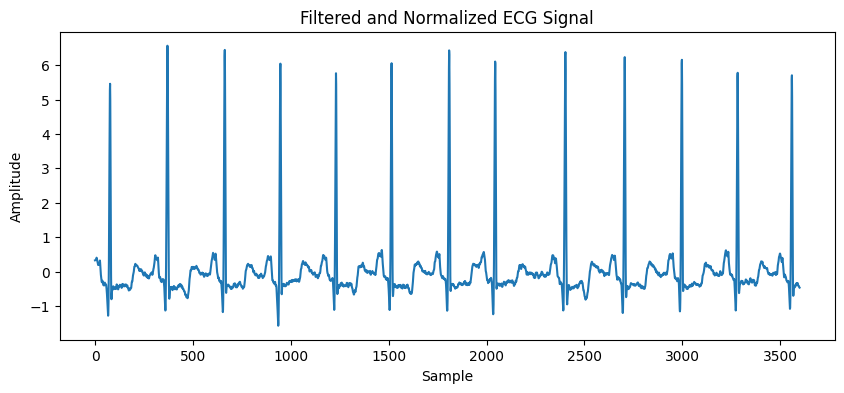

In [8]:
import scipy.signal as signal
import numpy as np

# Extract the signal (assuming it's the first signal in the record)
ecg_signal = record.p_signal[:, 0]

# Design a bandpass filter
lowcut = 0.5
highcut = 50.0
fs = record.fs
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(1, [low, high], btype='band')

# Apply the filter
filtered_ecg = signal.filtfilt(b, a, ecg_signal)

# Normalize the signal
normalized_ecg = (filtered_ecg - np.mean(filtered_ecg)) / np.std(filtered_ecg)

# Plot the filtered and normalized ECG signal
plt.figure(figsize=(10, 4))
plt.plot(normalized_ecg[:int(fs*10)])  # Plot the first 10 seconds
plt.title('Filtered and Normalized ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


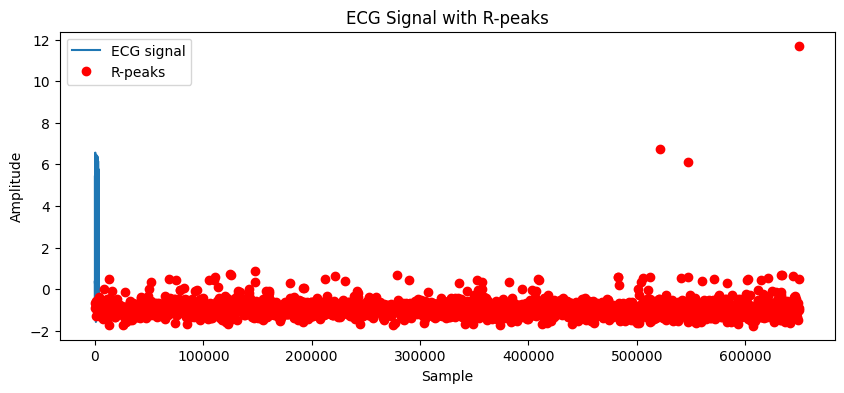

In [9]:
from wfdb import processing

# Find the R-peaks in the ECG signal
r_peaks = processing.gqrs_detect(sig=normalized_ecg, fs=fs)

# Plot the signal with R-peaks
plt.figure(figsize=(10, 4))
plt.plot(normalized_ecg[:int(fs*10)], label='ECG signal')
plt.plot(r_peaks, normalized_ecg[r_peaks], 'ro', label='R-peaks')
plt.title('ECG Signal with R-peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


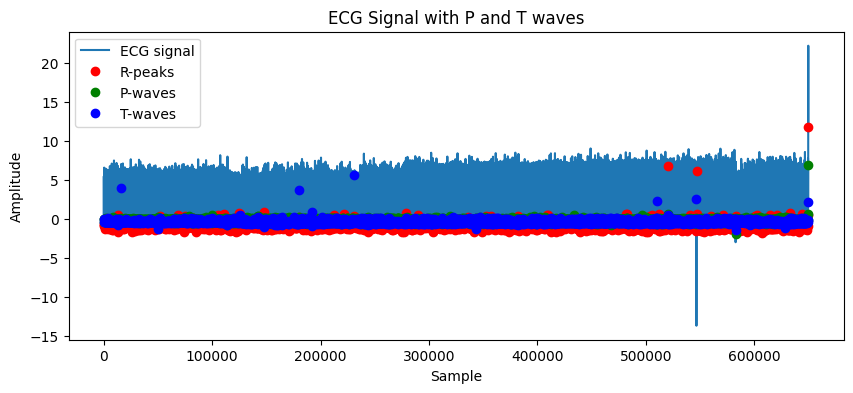

In [11]:
# Detect P and T waves (this is a simplified approach)
# In practice, more sophisticated algorithms are needed.

p_waves = r_peaks - int(0.2 * fs)  # Approximate location before R-peak
t_waves = r_peaks + int(0.2 * fs)  # Approximate location after R-peak

# Ensure indices are within bounds
p_waves = p_waves[p_waves < len(normalized_ecg)]
t_waves = t_waves[t_waves < len(normalized_ecg)]

# Plot P and T waves
plt.figure(figsize=(10, 4))
plt.plot(normalized_ecg, label='ECG signal')
plt.plot(r_peaks, normalized_ecg[r_peaks], 'ro', label='R-peaks')
plt.plot(p_waves, normalized_ecg[p_waves], 'go', label='P-waves')
plt.plot(t_waves, normalized_ecg[t_waves], 'bo', label='T-waves')
plt.title('ECG Signal with P and T waves')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
np.save('processed_ecg.npy', normalized_ecg)


##transformer based dnn on mith bih

In [6]:

import numpy as np
from sklearn.preprocessing import StandardScaler

# Load a sample record from the MIT-BIH dataset
record = wfdb.rdrecord('/content/drive/MyDrive/100_sample_ecg/100')
annotation = wfdb.rdann('/content/drive/MyDrive/100_sample_ecg/100', 'atr')

# Extract the signal and annotations
ecg_signal = record.p_signal[:, 0]  # Single-lead ECG
r_peaks = annotation.sample  # R-peak locations

# Normalize the ECG signal
scaler = StandardScaler()
normalized_ecg = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

# Segment the ECG signal into 3-second windows (assuming 360Hz sampling rate)
segment_length = 3 * 360  # 3 seconds
segments = [normalized_ecg[i:i+segment_length] for i in range(0, len(normalized_ecg)-segment_length, segment_length//2)]

# Example: Assign labels to each segment based on the presence of arrhythmia
labels = []
for i in range(0, len(normalized_ecg)-segment_length, segment_length//2): # Define 'i' to represent start index of each segment
    segment = normalized_ecg[i: i + segment_length]
    # Check if any R-peak in this segment corresponds to an arrhythmic beat
    if any(r in range(i, i+segment_length) for r in r_peaks):
        labels.append(1)  # Arrhythmia present
    else:
        labels.append(0)  # No arrhythmia



In [9]:
'''import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(InvertedResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
            nn.BatchNorm1d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class TransformerECG(nn.Module):
    def __init__(self, input_dim, n_classes, d_model=256, nhead=8, num_layers=4):
        super(TransformerECG, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            InvertedResidualBlock(32, 64, stride=2),
            nn.AdaptiveAvgPool1d(1)
        )
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))
        x = x.permute(2, 0, 1)  # (seq_len, batch, input_dim)
        # x = self.transformer(x)
        # Provide a dummy target sequence for the Transformer
        tgt = torch.zeros_like(x)  # You might need to adjust this based on your task
        x = self.transformer(x, tgt)
        x = self.fc(x[-1])  # Use the output of the last time step
        return x

# Example Usage
model = TransformerECG(input_dim=64, n_classes=4)
input_data = torch.randn(32, segment_length)  # 32 segments of length 3 seconds
output = model(input_data)'''


import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(InvertedResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
            nn.BatchNorm1d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class TransformerECG(nn.Module):
    def __init__(self, input_dim, n_classes, d_model=256, nhead=8, num_layers=4):
        super(TransformerECG, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            InvertedResidualBlock(32, 64, stride=2),
            nn.AdaptiveAvgPool1d(1)
        )
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers)
        # Adjust the input dimension of the linear layer to match d_model
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))
        x = x.permute(2, 0, 1)  # (seq_len, batch, input_dim)
        # Provide a dummy target sequence for the Transformer with the correct dimension
        tgt = torch.zeros(x.size(0), x.size(1), self.transformer.d_model, device=x.device)
        x = self.transformer(x, tgt)
        x = self.fc(x[-1])  # Use the output of the last time step
        return x

# Example Usage
model = TransformerECG(input_dim=64, n_classes=4)
input_data = torch.randn(32, segment_length)  # 32 segments of length 3 seconds
output = model(input_data)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: the feature number of src and tgt must be equal to d_model

In [10]:
import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(InvertedResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels),
            nn.BatchNorm1d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class TransformerECG(nn.Module):
    def __init__(self, input_dim, n_classes, d_model=256, nhead=8, num_layers=4):
        super(TransformerECG, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            InvertedResidualBlock(32, 64, stride=2),
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(64, d_model, kernel_size=1)  # Adjust output channels to match d_model
        )
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers)
        self.fc = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))  # Add channel dimension for CNN
        x = x.permute(2, 0, 1)  # (seq_len, batch, input_dim)
        x = self.transformer(x, x)  # Use x as both src and tgt since tgt isn't necessary
        x = self.fc(x[-1])  # Use the output of the last time step
        return x

# Example Usage
segment_length = 3 * 360  # 3 seconds of ECG data at 360Hz
model = TransformerECG(input_dim=64, n_classes=4, d_model=256)  # Ensure d_model matches the CNN output channels
input_data = torch.randn(32, segment_length)  # 32 segments of length 3 seconds
output = model(input_data)

print(output.shape)  # Should output (32, 4) indicating 32 samples classified into 4 classes


torch.Size([32, 4])


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# Example custom dataset for ECG data
class ECGDataset(Dataset):
    def __init__(self, segments, labels):
        self.segments = segments
        self.labels = labels

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = self.segments[idx]
        label = self.labels[idx]
        return torch.tensor(segment, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create dataset
ecg_segments = segments  # Assuming segments are already prepared as 3-second windows
ecg_labels = labels       # Corresponding labels for each segment

# Instantiate the dataset
ecg_dataset = ECGDataset(ecg_segments, ecg_labels)

# Create DataLoader
train_loader = DataLoader(ecg_dataset, batch_size=32, shuffle=True, num_workers=4)

# Now you can use train_loader in your training loop


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')


Epoch 1, Loss: 0.04103417028914249
Epoch 2, Loss: 4.770686916201253e-05
Epoch 3, Loss: 4.097907262085324e-05
Epoch 4, Loss: 3.593638183175292e-05
Epoch 5, Loss: 3.0894023774109024e-05
Epoch 6, Loss: 2.688059808669526e-05
Epoch 7, Loss: 2.3092084838457306e-05
Epoch 8, Loss: 1.9923533296892665e-05


KeyboardInterrupt: 